In [1]:
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from motion_torque import *

In [3]:
from ukf_se3 import UKF

In [4]:
from collections import namedtuple

CamState = namedtuple("CamState", ["P", "V", "W", "T"])

## Uncented Kalman filtering on SE3 manifold for two wheeled robot with visual odometry

We start from generating a GT trajectory of the left wheel

In [5]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def spiral(freq_x, freq_z, Rx, Rz, a, dt = 1, n=1000):
    time = np.arange(0, dt*n, dt)
    x = Rx * np.cos(freq_x * time)
    y = a * time
    z = Rz * np.sin(freq_z * time)

    tr = np.vstack([x, y, z]).transpose()

    vx = -Rx * np.sin(freq_x * time) * freq_x
    vy = np.full_like(time, a)
    vz = Rz * np.cos(freq_z * time) * freq_z

    vel_w = np.vstack([vx, vy, vz]).transpose()

    Rots = []
    ang_vels = []

    dt = time[1] - time[0]

    R_wfr = np.eye(3)
    for i in range(0, len(time) - 1):
        R_r1fr2 = rotation_matrix_from_vectors(vel_w[i+1], vel_w[i])
        Rots.append(R_wfr)
        R_wfr = np.matmul(R_wfr, R_r1fr2)
        
        w_r = Log3(R_r1fr2) / dt
        ang_vels.append(w_r)
    Rots.append(R_wfr)

    ang_vels.append(w_r)
    ang_vels = np.vstack(ang_vels)

    vel_r = []
    for (R, v) in zip(Rots, vel_w):
        vel_r.append(np.matmul(R.transpose(), v))

    poses = []
    for (R, t) in zip(Rots, tr):
        T = np.eye(4)
        T[:3,:3] = R
        T[:3, 3] = t
        poses.append(T)

    cam_poses = []

    for (P, v, w, t) in zip (poses, vel_r, ang_vels, time):
        cam_poses.append(CamState(P, v, w, t))

    return cam_poses
    

In [6]:
def plot_trajectory(T, title = "3D plot"):
    fig = plt.figure() 
    ax = fig.add_subplot(projection='3d')
      
    # creating the plot 
    plot_geeks = ax.plot(T[:, 0], T[:, 1], T[:, 2], color='green') 
      
    # setting title and labels 
    ax.set_title(title) 
    ax.set_xlabel('x-axis') 
    ax.set_ylabel('y-axis') 
    ax.set_zlabel('z-axis') 
      
    # displaying the plot 
    plt.show() 

We also need a helper that will calculate robot state from the left wheel trajectory.

Our state vector contains 3 parts: 1) Isometry3T(world_from_camera_rig) 2) left and right wheel angular velocity 2) left and right wheel torque

In [7]:
RobotState = namedtuple("RobotState", ["T_wfr", "W", "Torque", "time_s"])

class Helper:
    def __init__(self, T_left_wheel_from_rig, wheel_base: float, wheel_radius: float):
        self.T_lfr = T_left_wheel_from_rig
        self.d = wheel_base
        self.Rw = wheel_radius

        self.pred_state = None

    def robot_state(self, lw_state):
        T_wfr = np.matmul(lw_state.P, self.T_lfr)

        w_norm = np.linalg.norm(lw_state.W)
        if w_norm < 1e-6:
            W = lw_state.V / self.Rw
        else:
            R_l = np.cross(lw_state.V, lw_state.W) / (w_norm**2)
            R_r = R_l + np.array([self.d, 0, 0]) 
    
            wl = np.cross(lw_state.W, R_l)[2] /  self.Rw
            wr = np.cross(lw_state.W, R_r)[2] /  self.Rw
    
            W = np.array([wl, wr])

        torque = np.zeros(2)
        if self.pred_state is not None:
            torque = (W - self.pred_state[0]) / (lw_state.T - self.pred_state[1])

        self.pred_state = [W, lw_state.T]
        
        
        return RobotState(T_wfr, W, torque, lw_state.T)
        

Create a noised measurement from GT, assuming given measurement noise covariance - R.R is considered constant.

In [8]:
NoisedMeasurement = namedtuple("NoisedMeasurement", ["T_wfr", "time_s"])

def measure_with_noise(robot_state, R):
    x = np.random.normal(loc=0.0, scale=1.0, size=6)
    L = np.linalg.cholesky(R)
    return NoisedMeasurement(np.matmul(robot_state.T_wfr, Exp6(np.matmul(L, x))), robot_state.time_s)


We gonna need a few calibrations from carter model.

In [9]:
carter_wheel_base = 0.5
carter_wheel_radius = 0.14

T_left_wheel_from_rig = np.eye(4)
T_left_wheel_from_rig[:3, 3] = np.array([carter_wheel_base/2, 0, -1])

helper = Helper(T_left_wheel_from_rig, carter_wheel_base, carter_wheel_radius)

#### Initialize the motion model

In [10]:
model = WheeledRobotMotionModel(T_left_wheel_from_rig, carter_wheel_base, carter_wheel_radius)

In [11]:
from functools import partial
total_time = 10
trajectory_func = partial(spiral, 0.5, 1, 0.5, 0.3, 0.3)

### Test UKF on SE3 manifold

Let us first generate a certain trajectory of the left wheel, given timedelta and total mission time.

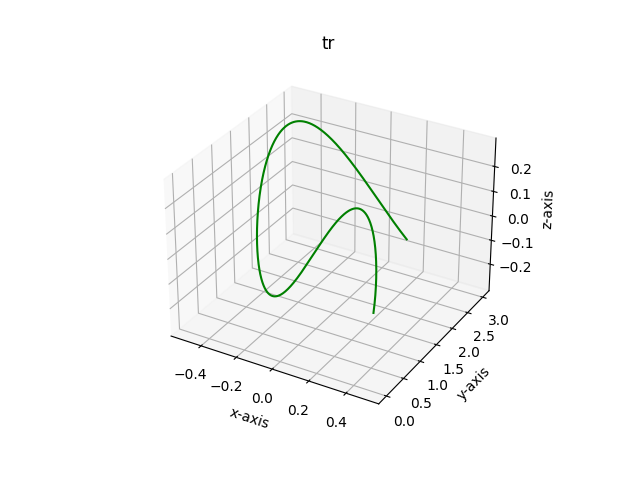

In [12]:
dt = 1e-2
n = total_time / dt

left_wheel_states = trajectory_func(dt, n)
# left_wheel_states = spiral(1.2, 2.4, 0.5, 0.3, 0, dt, n)
t = np.array([s.P[:3, 3] for s in left_wheel_states])
plot_trajectory(t, "tr")

Using the helper, build Robot states from left wheel positions.

In [13]:
robot_states = [helper.robot_state(s) for s in left_wheel_states]

In [14]:
# rs_W = np.array([x.W for x in robot_states])
# mean_W = np.mean(rs_W, axis=0)
# std_W = np.std(rs_W, axis=0)
# min_W = np.min(rs_W, axis=0)
# max_W = np.max(rs_W, axis=0)

# print(f"omega mean = {mean_W}, omega std = {std_W}, omega min = {min_W}, omega max = {max_W}")

### System noise covariance estimation

Q matrix describes how inacurate our prediction model is.
Indeed, carter prediction model can only predict poses on the plane w.r.t wheels.
But in reality road has bumps, or the control system changes the torque of the wheels, etc.

Senseless to make this matrix > R, as we want estimates with greater precision then the measurement. 
Making it too small will result into filter divergense, as the filter with rely more on incorrect prediction, then on measurements.
The best approach is to optimize it w.r.t a dataset.
Note: **** indirectly depends on dt! and gt trajectory curvature****

In order to estimate Q we will use the GT.
Algorithm:

For a certain time delta we will collect a list of GT robot states.
For every state in the list we gonna find a prediction of our kinematic model.

$$ state^{pred}_k = model.predict(state^{gt}_{k-1}, \Delta_t)$$

Calculate the $$Cov[state^{pred}_k, state^{gt}_{k+1}]$$


For a each timedelta is the list we will calculate an estimated Q.
Our goal is to model the dependensy of diagonal elements of Q from delta t.

In [15]:
def estimate_Q(model, states, delta_t):
    pred_states = []
    for s in states:
        pred_states.append(model.predict(s, delta_t))

    mean_sst = np.zeros((10, 10))
    for pred_s, true_s in zip(pred_states[:-1], states[1:]):
        diff = pred_s.substract(true_s)
        mean_sst += np.matmul(diff[:, np.newaxis], diff[:, np.newaxis].transpose())
    return mean_sst / (len(states) - 1)

Generate the list of Q:

In [51]:
time_detlas = np.linspace(1e-3, 1e-1, 30)
Qs = []
for dt in tqdm(time_detlas):
    lw_tr = trajectory_func(dt, total_time/dt)
    rs = [helper.robot_state(s) for s in lw_tr]
    states = [State(x.T_wfr, x.W, x.Torque) for x in rs]
    Qs.append(estimate_Q(model, states, dt))

diag_elements = np.array([q.diagonal() for q in Qs])

100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.69it/s]


Modeling the torque:

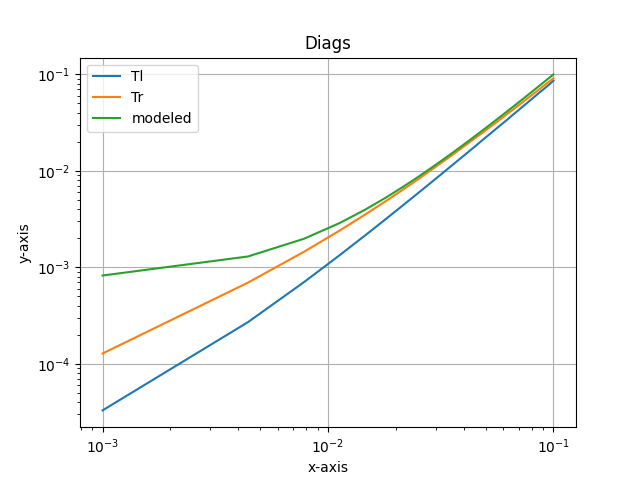

In [124]:
fig = plt.figure() 
ax = fig.add_subplot()

torque_var_wrt_time = np.square(3*(time_detlas + 5e-3)) + 5e-4
ax.plot(time_detlas, diag_elements[:, 8], label="Tl")
ax.plot(time_detlas, diag_elements[:, 9], label="Tr")
ax.plot(time_detlas, torque_var_wrt_time, label="modeled")
  
# setting title and labels 
ax.set_title("Diags") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
ax.set_yscale('log')
ax.set_xscale('log')

# displaying the plot 
plt.legend()
plt.grid()
plt.show() 

Modeling the angular velocity of the wheels:

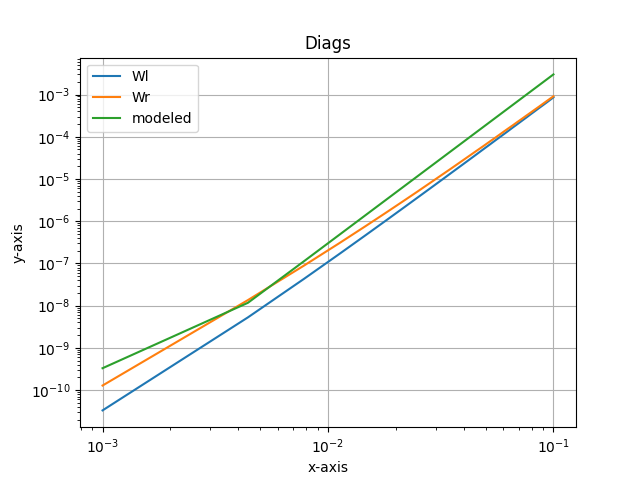

In [53]:
fig = plt.figure() 
ax = fig.add_subplot()

omega_var_wrt_time = 30 * np.power(time_detlas, 4) + 3e-10
ax.plot(time_detlas, diag_elements[:, 6], label="Wl")
ax.plot(time_detlas, diag_elements[:, 7], label="Wr")
ax.plot(time_detlas, omega_var_wrt_time, label="modeled")
  
# setting title and labels 
ax.set_title("Diags") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
ax.set_xscale('log')
ax.set_yscale('log')

# displaying the plot 
plt.legend()
plt.grid()
plt.show() 

Modeling the rotation part of the SE3 pose:

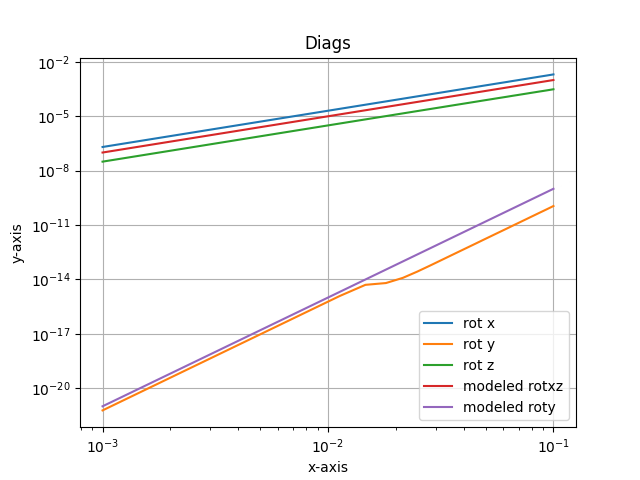

In [54]:
fig = plt.figure() 
ax = fig.add_subplot()

rotxz_wrt_time = 0.1 * np.power(time_detlas, 2)
roty_wrt_time = 1e-3 * np.power(time_detlas, 6)

ax.plot(time_detlas, diag_elements[:, 0], label="rot x")
ax.plot(time_detlas, diag_elements[:, 1], label="rot y")
ax.plot(time_detlas, diag_elements[:, 2], label="rot z")
ax.plot(time_detlas, rotxz_wrt_time, label="modeled rotxz")
ax.plot(time_detlas, roty_wrt_time, label="modeled roty")
  
# setting title and labels 
ax.set_title("Diags") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
ax.set_xscale('log')
ax.set_yscale('log')

# displaying the plot 
plt.legend()
plt.grid()
plt.show() 

Modeling the translation part of the SE3 pose:

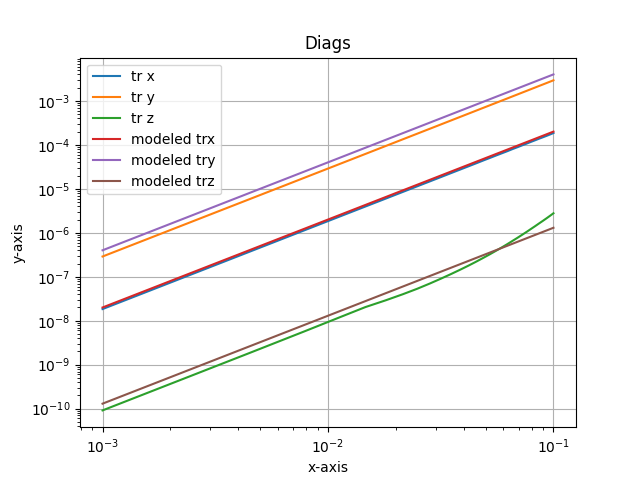

In [55]:
fig = plt.figure() 
ax = fig.add_subplot()

trx_var_wrt_time = 2e-2 * np.power(time_detlas, 2)
try_var_wrt_time = 4e-1 * np.power(time_detlas, 2)
trz_var_wrt_time = 1.3e-4 * np.power(time_detlas, 2)

ax.plot(time_detlas, diag_elements[:, 3], label="tr x")
ax.plot(time_detlas, diag_elements[:, 4], label="tr y")
ax.plot(time_detlas, diag_elements[:, 5], label="tr z")
ax.plot(time_detlas, trx_var_wrt_time, label="modeled trx")
ax.plot(time_detlas, try_var_wrt_time, label="modeled try")
ax.plot(time_detlas, trz_var_wrt_time, label="modeled trz")
  
# setting title and labels 
ax.set_title("Diags") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
ax.set_xscale('log')
ax.set_yscale('log')

# displaying the plot 
plt.legend()
plt.grid()
plt.show() 

Finally, we have come of with a good approximation of the Q wrt timedelta

In [56]:
def get_Q_hat(delta_t):
    rotxz_var = 0.1 * (delta_t ** 2)
    roty_var = 1e-3 * np.power(delta_t, 6)

    trx_var = 2e-2 * np.power(delta_t, 2)
    try_var = 4e-1 * np.power(delta_t, 2)
    trz_var = 1.3e-4 * np.power(delta_t, 2)

    omega_var = 30 * np.power(delta_t, 4) + 3e-10
    torque_var = np.square(3*(delta_t + 5e-3)) + 5e-4

    return np.diag([rotxz_var, roty_var, rotxz_var, trx_var, try_var, trz_var, omega_var, omega_var, torque_var, torque_var])

### Filter initialization

R - measurement noise covariance, i.e. visual odometry noise. Can be considered constant.

Q - system noise covariance

In [125]:
# measurement noise, heavy one
R = np.eye(6)*5e-3
# test
Q = get_Q_hat(dt) * 0.05

In [126]:
with np.printoptions(precision=4, suppress=True):
    print(Q)

[[0.0001 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0002 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0002 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0002 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.005  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.005 ]]


Start pose covariance cant be lower then the measurement noise.

Start angular velocity and torque covariances are initialized from common sense.

In [127]:
start = State(robot_states[0].T_wfr, robot_states[0].W, robot_states[0].Torque)

start_state_covariance = np.eye(start.order)
# we know start position with the accuracy of the measurement
start_state_covariance[:6, :6] = R
# w_max = 1
# we know almost nothing about the rest, initialize it from common sense
start_state_covariance[6:8,6:8] = np.eye(2) * 1e-1
start_state_covariance[8:,8:] = np.eye(2) * 0.2

Generate odometry measurements given R and GT trajectory

In [128]:
odometry_measurements = [measure_with_noise(x, R) for x in robot_states]

Create UKF filter

In [129]:
ukf = UKF(model, start, start_state_covariance, R, Q)

Lets filter our measurements

In [130]:
filtered_states = []
for m in tqdm(odometry_measurements):
    state, cov = ukf.update(m.T_wfr, m.time_s)
    filtered_states.append(state)

100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 32.01it/s]


In [131]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
class Arrow3D(FancyArrowPatch):

    def __init__(self, start, end, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = start
        self._dxdydz = end - start

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 
def _arrow3D(ax, start, end, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(start, end, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

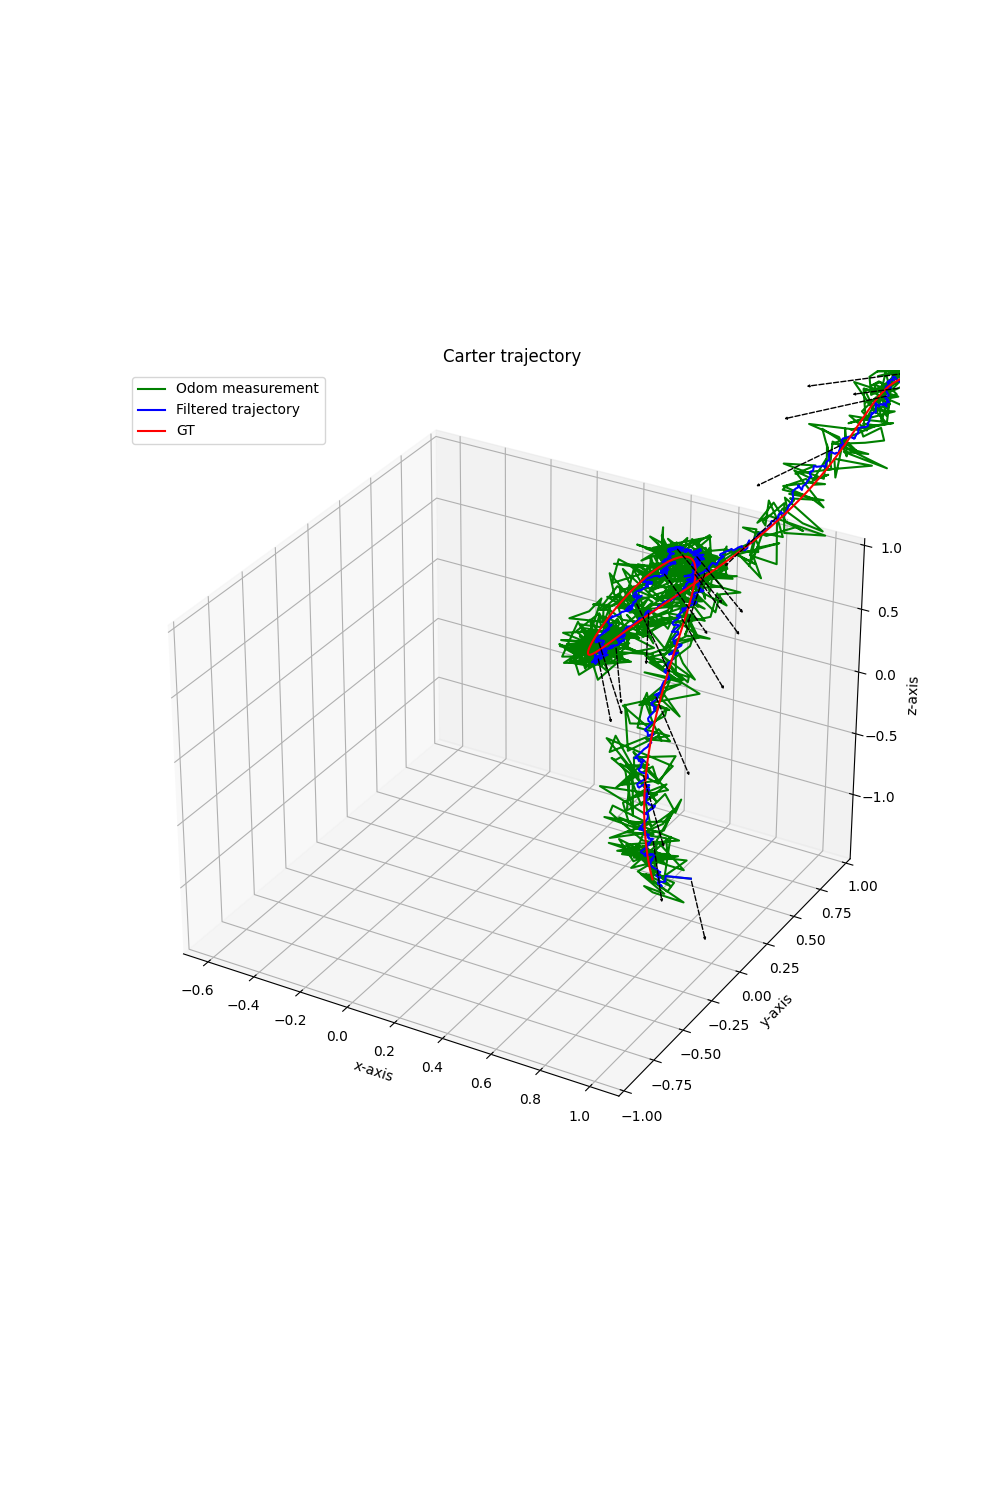

In [132]:
fig = plt.figure(figsize=(10, 15)) 
ax = fig.add_subplot(projection='3d')
  
# creating the plot 

T_m = np.array([s.T_wfr[:3, 3] for s in odometry_measurements])
T_cam = np.array([s.T_wfr[:3, 3] for s in robot_states])
T_kalman = np.array([s.T_wfr[:3, 3] for s in filtered_states])

#draw arrows
#take every nth predictions
N = 50
substates = filtered_states[::N]

for s in substates:
    t = s.T_wfr[:3, 3]
    delta = np.matmul(s.T_wfr[:3, :3].transpose(), np.array([0, 0, -1]))
    ax.arrow3D(t,
           t + delta * 0.5,
           mutation_scale=3,
           arrowstyle="-|>",
           linestyle='dashed')

ax.plot(T_m[:, 0],      T_m[:, 1],      T_m[:, 2], color='green', label="Odom measurement") 
ax.plot(T_kalman[:, 0], T_kalman[:, 1], T_kalman[:, 2], color='blue', label="Filtered trajectory")
ax.plot(T_cam[:, 0],    T_cam[:, 1],    T_cam[:, 2], color='red', label="GT")
  
# setting title and labels 
ax.set_title("Carter trajectory") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
ax.set_zlabel('z-axis') 
ax.set_ylim(-1, 1) 

  
# displaying the plot 
plt.legend()
plt.show() 

A good way to check if everything works well is to check the hidden variables of the state vector. Lets have a look at whell angular velocity.

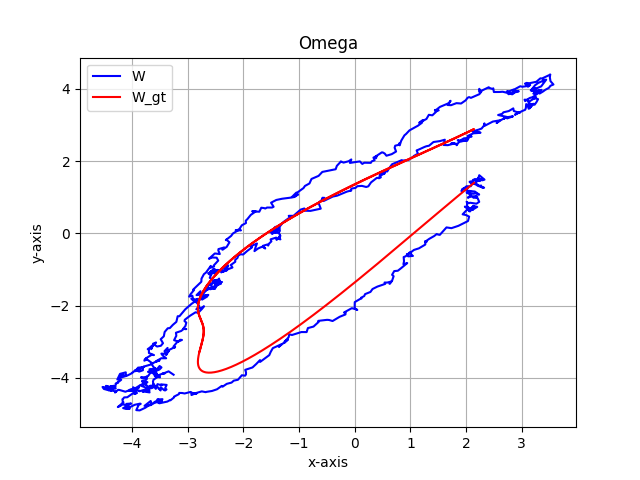

In [135]:
fig = plt.figure() 
ax = fig.add_subplot()
  
# creating the plot 
W = np.array([s.W for s in filtered_states])
W_gt = np.array([s.W for s in robot_states])
 
ax.plot(W[:, 0], W[:, 1], color='blue', label="W") 
ax.plot(W_gt[:, 0], W_gt[:, 1], color='red', label="W_gt") 
  
# setting title and labels 
ax.set_title("Omega") 
ax.set_xlabel('x-axis') 
ax.set_ylabel('y-axis') 
  
# displaying the plot 
plt.legend()
plt.grid()
plt.show() 

Thats is the state covariance at the end of the trajectory.

In [136]:
with np.printoptions(precision=3, suppress=True):
    print(cov)

[[ 0.     0.    -0.    -0.     0.     0.     0.    -0.     0.    -0.   ]
 [ 0.     0.    -0.    -0.     0.    -0.     0.    -0.001  0.001 -0.001]
 [-0.    -0.     0.     0.    -0.     0.    -0.     0.    -0.001  0.001]
 [-0.    -0.     0.     0.    -0.     0.    -0.002  0.002 -0.003  0.003]
 [ 0.     0.    -0.    -0.     0.001  0.    -0.    -0.    -0.    -0.   ]
 [ 0.    -0.     0.     0.     0.     0.     0.003  0.003  0.003  0.003]
 [ 0.     0.    -0.    -0.002 -0.     0.003  0.109  0.054  0.162  0.061]
 [-0.    -0.001  0.     0.002 -0.     0.003  0.054  0.111  0.06   0.164]
 [ 0.     0.001 -0.001 -0.003 -0.     0.003  0.162  0.06   0.407  0.075]
 [-0.    -0.001  0.001  0.003 -0.     0.003  0.061  0.164  0.075  0.409]]
